# Digital Musicology Project - Chord-based Characterization of Choruses and Verses in Pop and Rock Songs

# Research Question

# Presentation of the dataset

The dataset has been created by [1] and corresponds to a random sample of 890 Billboard chart slots presented at ISMIR 2011 and MIREX 2012. Due to the nature of the sampling algorithm, there are some duplicates and this results in only 585 distinct songs. 

This dataset is publicly available at https://ddmal.music.mcgill.ca/research/The_McGill_Billboard_Project_(Chord_Analysis_Dataset)/ and can be downloaded in various formats. Different features are given by the authors. In this project we will mostly rely on chords annotations. 

The main dataset comprehends chords, structure, instrumentation, and timing, given in a txt format. The annotation for each song begins with a header containing the title of the song, the name of the artist, the metre and the tonic pitch class of the opening key. In the main body, each line consists of a single phrase and begins with its timestamp, followed by the chords. This requires us to design a specific parser, as will be discussed in the next section.

An additional file gives more metadata informations such as the dates of the songs.

[1]: John Ashley Burgoyne, Jonathan Wild, and Ichiro Fujinaga, ‘An Expert Ground Truth Set for Audio Chord Recognition and Music Analysis’, in Proceedings of the 12th International Society for Music Information Retrieval Conference, ed. Anssi Klapuri and Colby Leider (Miami, FL, 2011), pp. 633–38

### Metadata informations

In [126]:
metadata_df = pd.read_csv("data/billboard-2.0-index.csv")
metadata_df.head(5)

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
0,1,1987-07-11,82,NaN,NaN,NaN,NaN,NaN
1,2,1973-08-04,14,NaN,NaN,NaN,NaN,NaN
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
4,5,1976-07-10,51,NaN,NaN,NaN,NaN,NaN


In [128]:
print('The songs range from %s to %s.' %(metadata_df.chart_date.min(), metadata_df.chart_date.max()))

The songs range from 1958-08-18 to 1991-11-16.


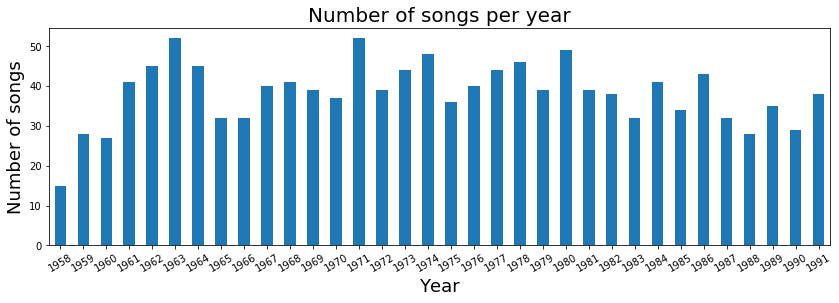

In [127]:
plt.figure(figsize = (14,4))
metadata_df.chart_date.map(lambda y:pd.to_datetime(y).year).value_counts(sort=False).plot(kind='bar')
plt.title("Number of songs per year", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Number of songs", fontsize = 18)
plt.xticks(rotation = 30)
plt.show()

We can see that our corpus is pretty well distributed over the considered period.

# Preprocessing of the songs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='white')
import plotly.express as px
import seaborn as sns
import researchpy as rp

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Parser for the songs</strong>
</div> 

In [2]:
SONG_ID, LINE_NUMBER, MEASURE_NUMBER, CHORD_NUMBER, SEQUENCE_NUMBER, \
CHORD, INSTRUMENT, TYPE, TIME, STRUCTURE, DURATION, REPETITION, ELID = \
"song_id","line_id", "measure_id", "chord_id", "sequence_id",\
"chord", "instrument", "section_type", "time", "section_structure", "duration", "repetition", "elided"

#This is dependant of "metre" in the txt files.
METRE = "metre"

#Create a new dictionary from two other
def immutable_merge(dic1, dic2):
    result = dic1.copy()
    result.update(dic2)
    return result

#Create a row of the futur df as a dictionary
def create_row(persistent_attributes, line_attributes,
               measure_number = None, chord_number = None, chord = None, duration = None):
    result = immutable_merge(persistent_attributes, line_attributes)
    
    if not (measure_number is None and measure_number is None and chord_number is None and duration is None):
        result[MEASURE_NUMBER] = measure_number
        result[CHORD_NUMBER] = chord_number
        result[CHORD] = chord
        result[DURATION] = duration
    
    return result

#Generate the attributes of a given line and update the sequence counter
def process_line_metadata(header, line_counter, old_line_attributes, sequence_counter, suffix = ""):
    
    result = {}
    
    #Suffix (main instrument, elid, repetition)
    old_instrument = str(old_line_attributes.get(INSTRUMENT))
    
    for suffix in suffix.split(", "):
        
        suffix = suffix.strip()
        
        #Repetition
        if re.match("^x\d+$",suffix):
            result[REPETITION] = int(suffix[1])
        
        #Elid
        elif suffix == "->":
            result[ELID] = True

        #Instrument
        else:
            ##New instrument
            if len(suffix) > 0 and suffix != "\n":
                result[INSTRUMENT] = suffix.strip("\n").strip(",").strip()

            ##Main instrument continued (experimental)
            elif not old_instrument.endswith(")") and old_instrument.lower() not in ["nan","none"] \
            and len(old_instrument)>0:
                result[INSTRUMENT] = old_instrument.strip("(")

        
    #Line number
    result[LINE_NUMBER] = line_counter

    
    #Header    
    header_items = header.split()
        
    result[TIME] = header_items[0]
    
    #Case where a section is continued
    if len(header_items) == 1:
        result[TYPE] = old_line_attributes.get(TYPE)
        result[STRUCTURE] = old_line_attributes.get(STRUCTURE)
        result[SEQUENCE_NUMBER] = old_line_attributes.get(SEQUENCE_NUMBER)
    
    #Case where a section has no structure (silence, end, fadeout)
    elif len(header_items) == 2:
        
        #Z is a structure, not a type.
        if header_items[1].strip().strip(",") == "Z":
            result[STRUCTURE] = header_items[1].strip().strip(",")
        else:
            result[TYPE] = header_items[1].strip().strip(",")
            
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    #Case where a section begins.
    elif len(header_items) == 3:
        result[STRUCTURE] = header_items[1].strip().strip(",")
        result[TYPE] = header_items[2].strip().strip(",")
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    return sequence_counter, result

In [3]:
def parse_song_to_dict(song_id, path):
    
    rows = []
    persistent_attributes = {}
    
    persistent_attributes[SONG_ID] = song_id
    
    with open(path,"r") as file:
        line = file.readline()
        
        line_counter = 0
        measure_counter = 0
        chord_counter = 0
        sequence_counter = 0
        line_attributes = {}
        old_chord = None
 

        while line:
        
            if line != "\n":

                #Attribute lines
                if line.startswith("#"):
                    attribute, value = line.strip("#").split(":",1)
                    persistent_attributes[attribute.strip(" ")] = value.strip(" ").strip("\n")

                else:
                    line_items = line.split("|")

                    #Special lines
                    if len(line_items) <= 1:
                        sequence_counter, line_attributes = \
                        process_line_metadata(line, line_counter, line_attributes, sequence_counter)
                        row = create_row(persistent_attributes, line_attributes)
                        rows.append(row)

                    #Standard lines    
                    else:                    
                        header = line_items[0]
                        suffix = line_items[-1]
                        measures = line_items[1:-1]

                        sequence_counter, line_attributes = \
                        process_line_metadata(header, line_counter, line_attributes, sequence_counter, suffix)  

                        for measure in measures:
                            
                            chords = measure.split()
                            
                            #Special metric (experimental)
                            old_metre = persistent_attributes.get(METRE)
                            if re.match("^\(\d/\d\)$", chords[0]):
                                persistent_attributes[METRE] = str(chords[0][1]) + "/" + str(chords[0][3])
                                chords = chords[1:]
                            
                            if len(chords) == 1:
                                duration = "measure"
                            elif len(chords) == 2 and persistent_attributes[METRE] in ["4/4","12/8"]:
                                duration = "half-measure"
                            else:
                                duration = "beat"
                            
                            for chord in chords:
                                
                                if chord == ".":
                                    chord = old_chord
                                
                                row = create_row(persistent_attributes, line_attributes,
                                                 measure_counter, chord_counter, chord, duration)
                                rows.append(row)
                                old_chord = chord
                                chord_counter += 1

                            measure_counter += 1
                            persistent_attributes[METRE] = old_metre
            
            #Finally
            line_counter += 1
            line = file.readline()
    
    
    return rows

In [4]:
def create_whole_collection_df():
    
    path = "data/McGill-Billboard/"
    file_name = "/salami_chords.txt"
    UPPER_BOUND = 1300
    
    whole_collection = []
    
    i = 0
    while i <= UPPER_BOUND:
        full_path = path + "0"*(4-len(str(i)))+ str(i) + file_name
        
        if os.path.exists(full_path):
            whole_collection += parse_song_to_dict(i, full_path)
        
        i += 1
        
    whole_collection_df = pd.DataFrame(whole_collection)
    
    return whole_collection_df.astype({SEQUENCE_NUMBER: 'Int64', MEASURE_NUMBER: 'Int64', CHORD_NUMBER: 'Int64', \
                                      REPETITION: 'Int64'})

In [5]:
collection_df = create_whole_collection_df()

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Parser for the chords</strong>
</div> 

We also define a parser to better handle the chords. This is based on the notation defined in [SYMBOLIC REPRESENTATION OF MUSICAL CHORDS: A PROPOSED SYNTAX FOR TEXT ANNOTATIONS](http://ismir2005.ismir.net/proceedings/1080.pdf) by C. Harte, M. Sandler, S. Abdallah and E. Gomez. Some notations are also added by the authors of the dataset and therefore included to handle all the 978 unique chords in the dataset. 

In [6]:
print('There are %d unique chords in the dataset.' %len(collection_df.chord.unique()))

There are 978 unique chords in the dataset.


In [7]:
#Split a string and changes the target field depending on which side of the split to take
#side : 0 for left and 1 for right
def split_add(c,dic,split_char,target,side):
    temp=str.split(str(c),split_char)

    dic[target]=temp[side]
    return dic, temp[1-side]


def chord_to_tab(c):
    c=str(c)
    chord={"root":"", "shorthand" : "", "degree_list":[], "bass":"", "N" :False}
    rest=""
    
    if(c=="N"):
        chord["N"] = True
        return chord
    
    c=c.replace(")","")
    
    if('/' in c):
        chord, rest=split_add(c,dic=chord,split_char="/",target="bass",side=1)
    else :
        rest=c
    if(':' in rest):
        chord, rest=split_add(rest,dic=chord,split_char=":",target="root",side=0)
    if('(' in rest):
        chord, rest=split_add(rest,dic=chord,split_char="(",target="degree_list",side=1)
    if(rest != ""):
        chord["shorthand"]=rest
    
    return chord

    

In [8]:
collection_df['chord_dic'] = collection_df.chord.map(lambda y : chord_to_tab(y))
for key in ['root', 'shorthand', 'degree_list', 'bass', 'N']:
    collection_df[key] = collection_df.chord_dic.map(lambda y: y[key])
collection_df.drop(columns = 'chord_dic', inplace = True)
#df = collection_df[['song_id', 'title', 'artist', 'tonic', 'section_type', 'sequence_id', 'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N']]

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of new columns of relative-to-tonic roots</strong>
</div> 

In [9]:
TPC_DIC = {"Cb":11,"C":0,"C#":1,"Db":1,"D":2,"D#":3,"Eb":3,"E":4,"E#":5,"Fb":4,"F":5,"F#":6,
           "Gb":6,"G":7,"G#":8,"Ab":8,"A":9,"A#":10,"Bb":10,"B":11,"B#":0}

In [10]:
collection_df["root_tpc"] = collection_df.root.apply(lambda r : TPC_DIC.get(r))
collection_df = collection_df.astype({"root_tpc":"Int64"})

In [11]:
collection_df["relative_root_tpc"] =\
collection_df.apply(lambda row: (row["root_tpc"] - TPC_DIC.get(row["tonic"]))%12,axis = 1)

In [12]:
collection_df = collection_df.fillna({REPETITION:1})

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of the dataframe with only songs that have both a verse and a chorus</strong>
</div> 

In [13]:
valid_songs = collection_df[[SONG_ID,TYPE]].drop_duplicates().groupby(SONG_ID)[TYPE].apply(list)\
.apply(lambda l: "chorus" in l and "verse" in l)

In [14]:
d_collection_df = collection_df.merge(valid_songs.reset_index().rename(columns = {TYPE:"valid"}),on = SONG_ID)
d_collection_df = d_collection_df[d_collection_df.valid].drop(columns = 'valid')

In [15]:
print('The corpus has %d songs.' %len(d_collection_df.song_id.unique()))

The corpus has 712 songs.



<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Dropping duplicates songs</strong>
</div>


In [16]:
ids_to_keep = d_collection_df[["song_id","title"]].drop_duplicates("title")["song_id"].values
d_collection_df = d_collection_df[d_collection_df.song_id.isin(ids_to_keep)]

In [17]:
print('The final corpus has %d songs.' %len(d_collection_df.song_id.unique()))

The final corpus has 585 songs.


<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of a one-row-per-beat dataframe</strong>
</div> 

Duration of measure: all metre in the corpus are regular except song 700 (5/8 = 3 + 2). This was counted as two beats.

In [18]:
def weight_row(metre, duration, repetition):
    """
    Indicate to how many beats in total a chord described on a dataframe's row correspond.
    Careful ! The chords are non-successive in case of repetition
    """
    num, denom = metre.split("/")
    
    if metre == "5/8": #Specific to this dataset
        beat_per_measure = 2
    else:
        beat_per_measure = int(num)/(1 if int(denom) == 4 else 3)
    
    if duration == "measure":
        return beat_per_measure*(repetition)
    
    elif duration == "half-measure":
        return beat_per_measure/2*(repetition)
    
    elif duration == "beat":
        return repetition
    
    else:
        return 0

def successive_repetition_row(metre,duration):
    """
    Indicate on how many successive beats a chord is present
    """
    return weight_row(metre,duration,repetition=1)

In [19]:
# Creation of one-row-per-bit dataframe
N_SUCC_BEATS = "n_succ_beats"

d_collection_df[N_SUCC_BEATS] = d_collection_df.apply(\
    lambda row: successive_repetition_row(row[METRE], row[DURATION]),axis=1)
d_collection_df = d_collection_df.astype({N_SUCC_BEATS:"Int64"})

In [20]:
from tqdm import tqdm

def create_beats_df(d_collection_df):
    beats_dics = []
    repetition_flag = False
    repeted_dics = []
    repetition_line = np.PINF
    repetition_song = np.PINF
    for i in tqdm(d_collection_df.reset_index().index):

        if repetition_flag == True and\
(repetition_line != d_collection_df.iloc[i][LINE_NUMBER] or repetition_song != d_collection_df.iloc[i][SONG_ID]):

            for r in range(repetition_n):
                beats_dics += repeted_dics

            repetition_flag = False
            repeted_dics = []
            repetition_line = np.PINF
            repetition_song = np.PINF
        
        
        if d_collection_df.iloc[i][REPETITION] == 1 :

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                beats_dics.append(d_collection_df.iloc[i].to_dict())

        else:

            repetition_flag = True
            repetition_line = d_collection_df.iloc[i][LINE_NUMBER]
            repetition_song = d_collection_df.iloc[i][SONG_ID]
            repetition_n = d_collection_df.iloc[i][REPETITION]

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                repeted_dics.append(d_collection_df.iloc[i].to_dict())

    beats_collection_df = pd.DataFrame(beats_dics)
    
    return beats_collection_df

In [21]:
beats_collection_df = create_beats_df(d_collection_df)
beats_collection_df = beats_collection_df.drop(N_SUCC_BEATS,axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 87919/87919 [01:08<00:00, 1289.16it/s]


Let's add the relative chord (using the relative root tpc previously obtained, the shorthand and the bass note).

In [22]:
beats_collection_df['relative_chord'] = beats_collection_df['relative_root_tpc'].astype(str) + beats_collection_df['shorthand'] + beats_collection_df['bass']

We will create new aggregated features, where we only consider the relative-to-the-tonic root of the chord and whether it's a major or a minor chord (or another chord quality).

In [23]:
def LabelMinMajChord(chord):
    label = 'other'
    if 'min' in chord: #This will label minmaj7 as a minor chord
        label = 'min' 
    elif 'maj' in chord:
        label = 'maj'
    return label

In [24]:
beats_collection_df['agg_chord_label'] = beats_collection_df['relative_root_tpc'].astype(str) + beats_collection_df['shorthand'].map(lambda x: LabelMinMajChord(x))

In [25]:
beats_collection_df[['song_id', 'title', 'artist', 'metre', 'tonic', 'section_type', 'sequence_id', 
                     'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N', 'root_tpc',
                     'relative_root_tpc', 'relative_chord', 'agg_chord_label']].sample(5)

,song_id,title,artist,metre,tonic,section_type,sequence_id,chord,root,shorthand,degree_list,bass,N,root_tpc,relative_root_tpc,relative_chord,agg_chord_label
175785,929,Dirty Water,Rock And Hyde,4/4,G,instrumental,2.0,C:maj,C,maj,[],,False,0.0,5.0,5.0maj,5.0maj
155217,807,You Took The Words Right Out Of My Mouth,Meat Loaf,4/4,G,verse,2.0,G:maj,G,maj,[],,False,7.0,0.0,0.0maj,0.0maj
88727,432,One Bad Apple,The Osmonds,4/4,C,chorus,6.0,A:min7,A,min7,[],,False,9.0,9.0,9.0min7,9.0min
133882,672,Baby Workout,Jackie Wilson,4/4,F,solo,5.0,F:7,F,7,[],,False,5.0,0.0,0.07,0.0other
38944,203,"Wonderful World, Beautiful People",Jimmy Cliff,4/4,D,chorus,2.0,A:maj,A,maj,[],,False,9.0,7.0,7.0maj,7.0maj


<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> the final dataframe beats_collection_df has the following properties:
    <ul>
        <li>each row corresponds to a beat and thus to a chord played</li>
        <li>only songs with both a verse and a chorus are kept</li>
        <li>all elements of a chord (root, quality, degree list and bass note) are given</li>
    </ul>
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Squeeze function</strong>
</div> 

As a last processing step, we define a function to obtain a dataframe with all the chords of a song squeezed in its various sections (intro, first verse, chorus, second verse...). This will be helpful later in our analysis.

In [26]:
#The squeeze function returns a dataframe with all the chords of a song squeezed in a row dependent on a subgroup
# of the section type. Default is "none" and will not filter any type of songs.
#try subgroup="chorus" or subgroup="verse"

def compress(s) :
    return s.dropna().to_list()

def squeeze(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    df_local = df_local.groupby(["song_id","title"])\
                        [["chord", "root", "shorthand", "bass", "relative_root_tpc", "relative_chord", "agg_chord_label"]]\
                        .agg(compress).reset_index()
    
    return df_local

In [27]:
squeeze(beats_collection_df).head()

,song_id,title,chord,root,shorthand,bass,relative_root_tpc,relative_chord,agg_chord_label
0,4,You've got a Friend,"[Ab:maj, Ab:maj, Ab:maj, Ab:maj, Db:maj/5, Db:...","[Ab, Ab, Ab, Ab, Db, Db, Db, Db, Ab, Ab, Ab, A...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , 5, 5, 5, 5, , , , , , , , , , , , , 5...","[0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 0.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj5, 5.0m...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj, 5.0ma..."
1,10,An Innocent Man,"[C:maj, C:maj, C:maj, C:maj, C:maj, C:maj, C:m...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0ma...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0ma..."
2,12,Lookin' for Love,"[E:min, E:min, E:min, E:min, F#:min, F#:min, F...","[E, E, E, E, F#, F#, F#, F#, G, G, G, G, A, A,...","[min, min, min, min, min, min, min, min, maj, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...","[2.0min, 2.0min, 2.0min, 2.0min, 4.0min, 4.0mi...","[2.0min, 2.0min, 2.0min, 2.0min, 4.0min, 4.0mi..."
3,16,She Bop,"[A:min, A:min, A:min, A:min, A:min, A:min, A:m...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...","[min, min, min, min, min, min, min, min, min, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0min, 0.0min, 0.0min, 0.0min, 0.0min, 0.0mi...","[0.0min, 0.0min, 0.0min, 0.0min, 0.0min, 0.0mi..."
4,18,Kiss On My List,"[C:maj, C:maj, G:maj/11, G:maj/11, A:min/b3, A...","[C, C, G, G, A, A, G, G, C, C, C, C, C, C, C, ...","[maj, maj, maj, maj, min, min, maj, maj, min7,...","[, , 11, 11, b3, b3, 11, 11, , , , , , , , , ,...","[0.0, 0.0, 7.0, 7.0, 9.0, 9.0, 7.0, 7.0, 0.0, ...","[0.0maj, 0.0maj, 7.0maj11, 7.0maj11, 9.0minb3,...","[0.0maj, 0.0maj, 7.0maj, 7.0maj, 9.0min, 9.0mi..."


In [28]:
#squeeze section allows you to squeeze the sections of songs
def squeeze_section(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    
    df_local = df_local.groupby(["song_id","title","sequence_id","section_type"])\
                        [["chord", "root", "shorthand", "bass", "relative_root_tpc", "relative_chord", "agg_chord_label"]]\
                        .agg(compress).reset_index()
    df_local['sequence_id'] = df_local['song_id'].astype(str) + ":" + df_local['sequence_id'].astype(int).astype(str)
    
    return df_local

In [29]:
squeeze_section(beats_collection_df).head()

,song_id,title,sequence_id,section_type,chord,root,shorthand,bass,relative_root_tpc,relative_chord,agg_chord_label
0,4,You've got a Friend,4:1,intro,"[Ab:maj, Ab:maj, Ab:maj, Ab:maj, Db:maj/5, Db:...","[Ab, Ab, Ab, Ab, Db, Db, Db, Db, Ab, Ab, Ab, A...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , 5, 5, 5, 5, , , , , , , , ]","[0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 0.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj5, 5.0m...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj, 5.0ma..."
1,4,You've got a Friend,4:2,verse,"[F:min, F:min, F:min, F:min, C:7/5, C:7/5, C:7...","[F, F, F, F, C, C, C, C, F, F, C, C, F, C, F, ...","[min, min, min, min, 7, 7, 7, 7, min, min, 7, ...","[, , , , 5, 5, , , , , 5, 5, b3, 5, , , , , , ...","[9.0, 9.0, 9.0, 9.0, 4.0, 4.0, 4.0, 4.0, 9.0, ...","[9.0min, 9.0min, 9.0min, 9.0min, 4.075, 4.075,...","[9.0min, 9.0min, 9.0min, 9.0min, 4.0other, 4.0..."
2,4,You've got a Friend,4:3,pre-chorus,"[G:hdim7, G:hdim7, G:hdim7, G:hdim7, C:7, C:7,...","[G, G, G, G, C, C, C, C, F, F, C, C, F, C, F, ...","[hdim7, hdim7, hdim7, hdim7, 7, 7, 7, 7, min, ...","[, , , , , , , , , , 5, 5, b3, 5, , , , , , , ...","[11.0, 11.0, 11.0, 11.0, 4.0, 4.0, 4.0, 4.0, 9...","[11.0hdim7, 11.0hdim7, 11.0hdim7, 11.0hdim7, 4...","[11.0other, 11.0other, 11.0other, 11.0other, 4..."
3,4,You've got a Friend,4:4,chorus,"[Ab:maj, Ab:maj, Ab:maj, Ab:maj, Ab:7, Ab:7, A...","[Ab, Ab, Ab, Ab, Ab, Ab, Ab, Ab, Db, Db, Db, D...","[maj, maj, maj, maj, 7, 7, 7, 7, maj, maj, maj...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.07, 0.07, 0...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0other, 0.0..."
4,4,You've got a Friend,4:5,bridge,"[Gb:maj(9), Gb:maj(9), Gb:maj(9), Gb:maj(9), D...","[Gb, Gb, Gb, Gb, Db, Db, Db, Db, Ab, Ab, Ab, A...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[10.0, 10.0, 10.0, 10.0, 5.0, 5.0, 5.0, 5.0, 0...","[10.0maj, 10.0maj, 10.0maj, 10.0maj, 5.0maj, 5...","[10.0maj, 10.0maj, 10.0maj, 10.0maj, 5.0maj, 5..."


# Analysis

## Dimensionality Reduction - Is it Possible to Distinguish Verses and Choruses in Low-Dimensional Spaces?

### Bag of Words Representation

We will rely on the Bag of Words representation to represent the verse and chorus sequences of the songs in feature space, where different features can be used. Before going in the details of the different features that can be used, we quickly present the general idea of the Bag of Words representation.

It relies on first defining a vocabulary corresponding to all the possible features considered, then count the occurences of each feature in a given sequence and finally normalize the obtained vector by the total number of elements in the sequence. This ensures the following properties for the BoW vector $X$ of size d obtained:

\begin{equation}
0 \le X_i \le 1,  \forall i = 1,...,d
\end{equation}

\begin{equation}
\sum_{i = 1}^d X_i = 1
\end{equation}

Note that d corresponds to the number of features considered.

In our particular case, different features can be considered. The most obvious one is simply taking all the possible chords used in our corpus, either with an absolute root or a relative-to-the-tonic root. 

Another choice to make is how to consider the different occurences of a section type in a song. Consider for instance a song with the following outline: (intro, verse1, chorus1, verse2, chorus2, outro). Two possibles representations can be chosen here:
* concatenated representation: one verse concatenating verse1 and verse2 chords and one chorus concatenating chorus1 and chorus2, and the compute the BoW on the concatenated sequence of chords
* individual representation: directly compute the BoW on each individual section, thus getting two verse BoW and two chorus BoW

A priori both these representations have some drawbacks. Indeed, in the first case the results might be skewed by the overall differences bewteen songs while in the second case they could be skewed by the internal differences between various verses or choruses of a song. Thus we will later compare these two representations and test our dimensionality reduction methods on both.

To compute the BoW representations, we  start by creating the two vocabularies (the list of features used).

In [98]:
vocab_absolute = dict.fromkeys(beats_collection_df.chord.unique(), 0) 
vocab_relative = dict.fromkeys(beats_collection_df.relative_chord.unique(), 0) 

Let's remove the non-chords elements.

In [99]:
for non_chord in ['', '&pause', 'nan', 'nan*']:
    vocab_absolute.pop(non_chord, None)
    vocab_relative.pop(non_chord, None)

In [100]:
print("When considering absolute roots, we have %d features." %len(vocab_absolute))
print("When considering relative roots, we have %d features." %len(vocab_relative))

When considering absolute roots, we have 859 features.
When considering relative roots, we have 444 features.


We can then define some functions to compute the BoW representations.

In [32]:
def createBOW(chord_list, vocab):
    '''
    This function take a list of "words" and return the corresponding Bag of Words, using the provided vocabulary.
    '''
    bow = dict.fromkeys(vocab.keys(), 0)
    for chord in chord_list:
        if chord in bow.keys():
            bow[chord] += 1
    #Normalise the BoW to get a distribution
    total = sum(bow.values())
    if total != 0:
        bow = {chord: count/total for chord, count in bow.items()}
    return bow

In [33]:
def createBOW_df_section(df, section, vocab, chord):
    '''
    This function takes a dataframe containing all the chords of the songs and computes the BoW for each concatenated section 
    of the specified type using the given vocabulary. 
    The parameter "chord" allows to select the type of "words" to be used for the BoW.
    '''
    df_squeezed = squeeze(df, section)
    bow_dict = createBOW(df_squeezed[chord].iloc[0], vocab)
    data = pd.DataFrame(bow_dict, index = [0])
    for i in range(1, len(df_squeezed.song_id.unique())):
        bow_dict = createBOW(df_squeezed[chord].iloc[i], vocab)
        data = data.append(pd.DataFrame(bow_dict, index = [i]))
    data['song_id'] = df_squeezed.song_id.unique()    
    
    return data[["song_id"] + list(vocab.keys())]

In [34]:
def createBOW_df_individual_sequence(df, section, vocab, chord):
    '''
    This function takes a dataframe containing all the chords of the songs and computes the BoW for each individual section 
    of the specified type using the given vocabulary. 
    The parameter "chord" allows to select the type of "words" to be used for the BoW.
    '''
    df_squeezed = squeeze_section(df, section)
    bow_dict = createBOW(df_squeezed[chord].iloc[0], vocab)
    data = pd.DataFrame(bow_dict, index = [0])
    for i in range(1, len(df_squeezed.sequence_id.unique())):
        bow_dict = createBOW(df_squeezed[chord].iloc[i], vocab)
        data = data.append(pd.DataFrame(bow_dict, index = [i]))
    data['sequence_id'] = df_squeezed.sequence_id    
    
    return data[["sequence_id"] + list(vocab.keys())]

First, we create the bow representation of concatenated sections corresponding to the given section, in absolute tpc.

In [35]:
df_bow_verse = createBOW_df_section(df = beats_collection_df, 
                                    vocab = vocab_absolute,
                                    section = "verse",
                                    chord = "chord")
df_bow_chorus = createBOW_df_section(df = beats_collection_df, 
                                     vocab = vocab_absolute,
                                     section = "chorus", 
                                     chord = "chord")

Then the same in relative to the tonic tpc.

In [36]:
df_bow_verse_rel = createBOW_df_section(df = beats_collection_df, 
                                        section = "verse", 
                                        vocab = vocab_relative, 
                                        chord = "relative_chord")
df_bow_chorus_rel = createBOW_df_section(df = beats_collection_df, 
                                         section = "chorus", 
                                         vocab = vocab_relative, 
                                         chord = "relative_chord")

And finally we create the bow representation for individual sections. Here as well we use the relative to the tonic tpc.

In [37]:
df_bow_chorus_rel_seq = createBOW_df_individual_sequence(df = beats_collection_df, 
                                                         section = "chorus", 
                                                         vocab = vocab_relative, 
                                                         chord = "relative_chord")
df_bow_verse_rel_seq = createBOW_df_individual_sequence(df = beats_collection_df, 
                                                        section = "verse", 
                                                        vocab = vocab_relative, 
                                                        chord = "relative_chord")

#### Considerations on whether to consider each section individually or concatenated together by song

Before actually applying our dimensionality reduction methods on the BoW we have just computed, we should test whether the two sequence representation (concatenated or individual) are similar enough or not. To do so, we propose two methods:
* compute the differences between the BoW of a song, averaged over all the individual sections for that song, and the BoW obtained when concatenating all these sections
* compute the cosine distances between the BoW of the individual sections of a song and the BoW obtained when concatenating all the corresponding sections

The [SciPy](https://www.scipy.org/) library is used to streamline our computations.

In [102]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cosine

In [39]:
df_bow_chorus_rel_seq['song_id'] = df_bow_chorus_rel_seq['sequence_id'].map(lambda x: int(x.split(':')[0]))
df_bow_verse_rel_seq['song_id'] = df_bow_verse_rel_seq['sequence_id'].map(lambda x: int(x.split(':')[0]))

In [40]:
def ComputeDifferences_MeanBoWSection_BoWSong(df1, df2, vocab, section):
    '''
    This function computes the differences between the mean BoW of each section of a song taken individually 
    and the BoW of the song when concatening all the sequences of the given section type.
    '''
    diff = (df1.groupby('song_id').mean().reset_index()[vocab.keys()] - df2[vocab.keys()]).mean()
    plt.figure(figsize = (14,4))
    diff.plot(kind = 'hist', bins = 100, fontsize = 14)
    title = 'Distribution of the differences between \n the mean BoW of each section of a song and the BoW of the song (' + section + ')'
    plt.title(title, fontsize = 20)
    plt.xlabel('Difference', fontsize = 18)
    plt.ylabel('Number of songs', fontsize = 18)
    plt.show()
    
    print("Statistics:")
    print(rp.summary_cont(diff))

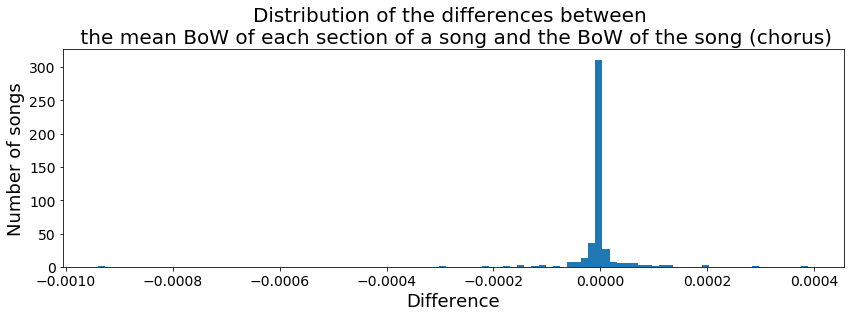

Statistics:


   Variable      N      Mean        SD        SE  95% Conf.  Interval
0       NaN  444.0 -0.000002  0.000061  0.000003  -0.000008  0.000004


In [41]:
ComputeDifferences_MeanBoWSection_BoWSong(df1 = df_bow_chorus_rel_seq, 
                                          df2 = df_bow_chorus_rel, 
                                          vocab = vocab_relative, 
                                          section = "chorus")

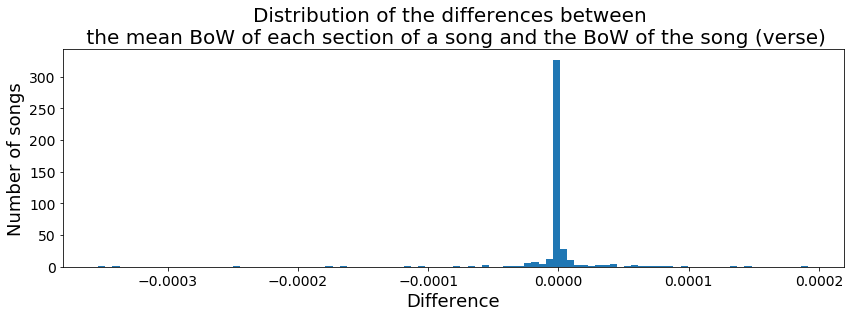

Statistics:


   Variable      N          Mean        SD        SE  95% Conf.  Interval
0       NaN  444.0 -9.625010e-07  0.000036  0.000002  -0.000004  0.000002


In [42]:
ComputeDifferences_MeanBoWSection_BoWSong(df1 = df_bow_verse_rel_seq, 
                                          df2 = df_bow_verse_rel, 
                                          vocab = vocab_relative, 
                                          section = "verse")

With this first method, we can see that the differences are distributed with a clear pick around 0. We also notice that there seem to be some outliers but the absolute differences overall remain extremely small, under 0.001. It is worthwhile noting that the outliers have bigger differences for the choruses, perhaps because there are bigger differences between individual choruses of those songs.

In [43]:
def ComputeCosineDistances_BoWSection_FullBoW(df1, df2, vocab, section):
    '''
    This function computes the cosine distances between the BoW of each section of a song taken individually 
    and the BoW of the song when concatening all the sequences of the given section type.
    '''
    diff = []
    for seq_id in df1.sequence_id.unique():
        diff.append(cosine(df1[df1.sequence_id == seq_id][vocab.keys()].squeeze(),
                           df2[df2.song_id == int(seq_id.split(':')[0])][vocab].squeeze()))
    plt.figure(figsize = (14,4))
    plt.hist(diff, bins = 100)
    title = 'Distribution of the cosine distances between \n the BoW of each section of a song and the full BoW of the song (' + section + ')'
    plt.title(title, fontsize = 20)
    plt.xlabel('Cosine Distance', fontsize = 18)
    plt.ylabel('Number of \n Individual Section / Full Song Pairs', fontsize = 18)
    plt.show()
    
    print("Statistics:")
    print(rp.summary_cont(pd.Series(diff)))

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\giaco\Anaconda3\envs\ada\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



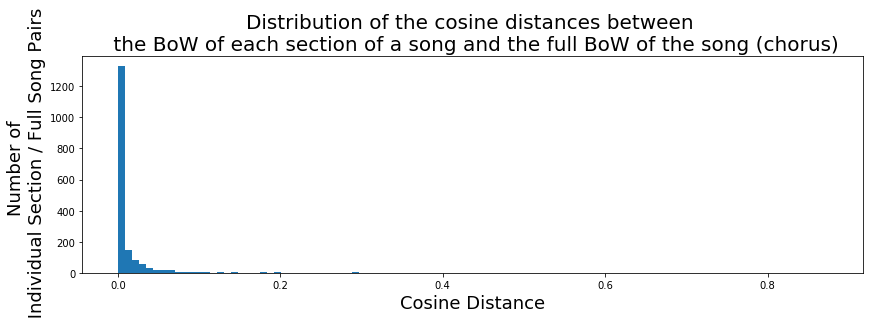

Statistics:


   Variable       N      Mean        SD        SE  95% Conf.  Interval
0       NaN  1887.0  0.028152  0.086602  0.001994   0.024242  0.032062


In [44]:
ComputeCosineDistances_BoWSection_FullBoW(df1 = df_bow_chorus_rel_seq, 
                                          df2 = df_bow_chorus_rel, 
                                          vocab = vocab_relative, 
                                          section = "chorus")

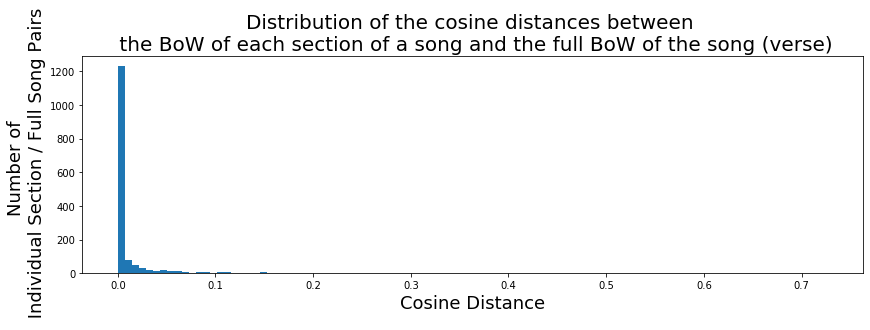

Statistics:


   Variable       N      Mean        SD        SE  95% Conf.  Interval
0       NaN  1586.0  0.019987  0.073937  0.001857   0.016346  0.023629


In [45]:
ComputeCosineDistances_BoWSection_FullBoW(df1 = df_bow_verse_rel_seq, 
                                          df2 = df_bow_verse_rel, 
                                          vocab = vocab_relative, 
                                          section = "verse")

With this second method, the results are very similar, with a distribution clearly peaked at 0. Again the cosine distances are slightly higher for choruses but overall the two representations (concatenated or individual sequences) seem to be very similar.

#### Aggregated features

Finally, since when considering all chords we end up with large feature spaces (over 400-dimension spaces for the relative chords and over 800-dimension spaces for the absolute chords), we try to aggregate them and create a new set of features. To do so, we consider the relative-to-the-tonic root (in tpc) and we classify the quality of the chord as "major", "minor" or "other". Note these features are already obtained for each chord in the preprocessing steps.

In [106]:
def PlotAggregatedFeaturesCount(section):
    '''
    This function plots the occurences of the aggregated features on the whole corpus, on the specified section type.
    '''
    plt.figure(figsize = (14,4))
    beats_collection_df[beats_collection_df.section_type == section]['agg_chord_label'].value_counts().plot(kind = 'bar')
    title = 'Number of chords for the new aggregated features on the ' + section
    plt.title(title, fontsize = 20)
    plt.xlabel('Aggregated feature', fontsize = 18)
    plt.xticks(rotation = 45)
    plt.ylabel('Number of chords', fontsize = 18)
    plt.show()

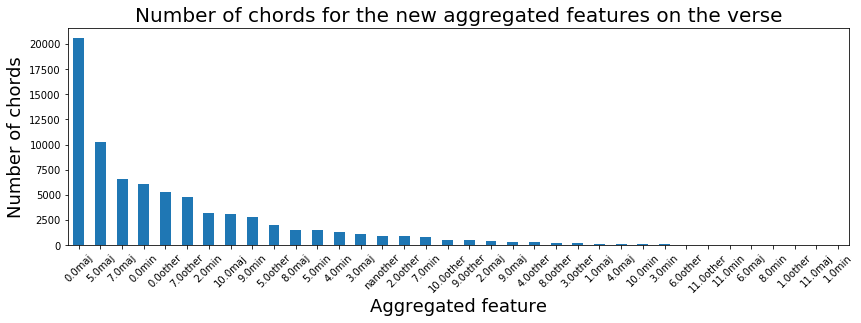

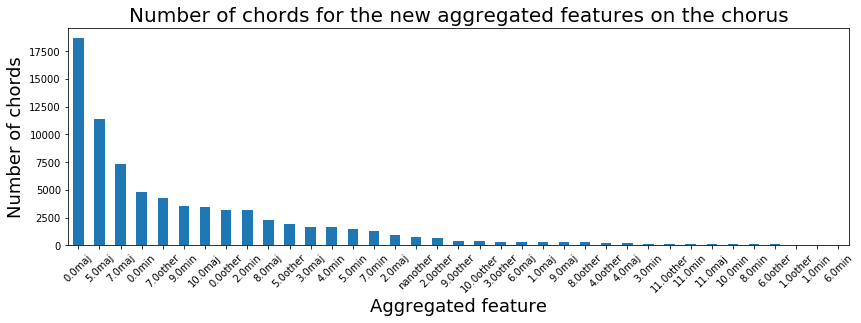

In [107]:
for section in ['verse', 'chorus']:
    PlotAggregatedFeaturesCount(section = section)

As we can see, both on the verses and the choruses, most of the chords are in major, with a main presence of 0maj, 5maj and 7maj, followed by 0min. This of course reflects the importance of the tonic and the dominant in Western music.

We still need to remove the chord starting with nan.

In [48]:
features_agg = beats_collection_df.agg_chord_label.unique()
features_agg = np.delete(features_agg, 13)
features_agg = dict.fromkeys(features_agg, 0)

With this newly created features, we end up with a 36-dimension space (meaning that all combinations of relative root and chord quality are present in our corpus).

In [49]:
print('There are %d aggregated features.' %len(features_agg.keys()))

There are 36 aggregated features.


We can now create the new BoW representations for the verses and the choruses using the new aggregated features, by considering the concatenated representation of sequences (arbitrary choice, since the two representations are very similar).

In [110]:
df_bow_verse_agg = createBOW_df_section(df = beats_collection_df, 
                                        section = 'verse', 
                                        vocab = features_agg, 
                                        chord = 'agg_chord_label')
df_bow_chorus_agg = createBOW_df_section(df = beats_collection_df, 
                                         section = 'chorus', 
                                         vocab = features_agg, 
                                         chord = 'agg_chord_label')

### Dimensionality Reductions Method

Dimensionality reduction is the process of reducing the number of features needed to represent a dataset, thus reducing the dimensionality of the space in which the dataset lies. This can be used either to find features that explain the data better or even to reduce the dimension low-enough so that it can be represented (thus on a 2D or 3D plot).

There are various methods to do so and in this project we rely on four of them: 
* Principal Component Analysis (PCA)
* Independent Component Analysis (ICA)
* t-distributed Stochastic Neighbor Embedding (tSNE)
* Non-Negative Matrix Factorization (NMF)

In this section we will first explain these three methods and present the functions used to train the model and plot the results. Some utilitu functions to better investigate the results are also presented.

We will use the scikit-learn Python library, presented by [Scikit-learn: Machine Learning in Python](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

We define a few absolute constants to homogenize the plots for the dimensionality reduction methods. 

In [51]:
ALPHA = 0.2
FIGSIZE = (6,6)
TITLE_FS = 18
AX_LABEL_FS = 16

#### Principal Component Analysis (PCA)

Perhaps the most used dimensionality reduction method, PCA performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. This ensures that the Principal Components obtained best explain the data since they explain most of its variance.

From a mathematical point of view, the transformation from the high-dimensional space to the lower-dimensional space is defined by a set of vectors $\vec{w}_{(k)}$ that map linearly each data sample $\vec{x}_{(i)}$ to a Principal Component $\vec{t}_{(i)}$ given by $t_{k(i)} = \vec{x}_{(i)} \cdot \vec{w}_{(k)}$. The weights $\vec{w}_{(k)}$ are iteratively obtained by maximizing the variance $\sum_{i} (\vec{t}_{(i)})^2 = \sum_{i} (\vec{x}_{(i)} \cdot \vec{w}_{(k)})^2$.

The [scikit-learn implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) presents in details all the parameters. The important ones here are:
* the number of components n_components (either an integer value specifying the number of Principal Components wanted or a float number specifying the amount of variance that we want to explain)
* the svd_solver used for the Singular Value Decomposition
* the random_state (in this case, the seed used by the random number generator)

In [52]:
from sklearn.decomposition import PCA

In [53]:
def PCA_visualization(df_verse, df_chorus, vocab, n_comps):
    '''
    This function train the PCA model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The number of Principal Components we want is specified.
    Once the model is trained, the PCs are plotted in 2D, coloring the verses in red and the choruses in blue.
    '''
    #Train the pca model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    pca_model = PCA(n_components = n_comps, svd_solver = "full", random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = pca_model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['PC1'], 
                principalDf[principalDf.label == 0]['PC2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['PC1'], 
                principalDf[principalDf.label == 1]['PC2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', #components: 2)'
    title = 'PCA on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('PC1', fontsize = AX_LABEL_FS)
    plt.ylabel('PC2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()
    
    return pca_model

In [54]:
def PCA_explainedVariance(df_verse, df_chorus, vocab, prop_variance, num_PCs):
    '''
    This function aims at finding the number of PCs to explain a given proportion of variance 
    and also print the explained variance for the first num_PCs components.
    '''
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    pca_model = PCA(n_components = prop_variance,
                    svd_solver = "full", 
                    random_state = 42)
    pca_model.fit(X)
    print('The mininum number of PCs to explain %0.2f%% of the variance is %d.' % (100 * prop_variance, pca_model.n_components_))
    for (pc_i, var_ratio) in enumerate(pca_model.explained_variance_ratio_[:num_PCs]):
        print('The PC%d explains %0.2f%% of the total variance.' % (pc_i + 1, 100 * var_ratio))

In [55]:
def InspectWeightVector(weights, pc, features, n_weights, model_name):
    '''
    This function helps investigate the weights vectors w output by the model (used both for PCA and for ICA).
    It plots in a barplot the top n_weights elements from the sorted weight vector elements, 
    where each weight vector corresponds to a given feature of the data in the high-dimensional space.
    '''
    pc_id = pc - 1
    top_positive_weights = pd.DataFrame(columns = features, data = weights)\
                                                .iloc[pc_id].sort_values(ascending = False)[:n_weights]
    top_negative_weights = pd.DataFrame(columns = features, data = weights)\
                                                .iloc[pc_id].sort_values(ascending = True)[:n_weights].sort_values(ascending = False)
    plt.figure(figsize = (10,3))
    plt.bar(x = range(n_weights), height = top_positive_weights)
    plt.bar(x = range(-n_weights, 0), height = top_negative_weights)
    plt.xticks(range(-n_weights, n_weights), top_negative_weights.index.append(top_positive_weights.index), rotation = 30)
    title = 'Importance of each feature in Comp' + str(pc) + '\n of the ' + model_name + ' model (top ' + str(n_weights) + ')'
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Feature', fontsize = AX_LABEL_FS)
    plt.ylabel('Importance of the Feature', fontsize = AX_LABEL_FS)
    plt.grid(True, alpha = 0.5)
    plt.show()

#### Independent Component Analysis (ICA)

ICA aims at separating a data set into independent non-Gaussian components. From a mathematical point of view, the goal is to find the weights $W$ such as $\vec{s} = W\vec{x}$ with $\vec{x}$ the observed sample vectors and $\vec{s}$ a vector of maximally independent components, where the independence can be measured in different ways.

The [scikit-learn implementation of ICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html?highlight=ica#sklearn.decomposition.FastICA) uses FastICA, a fast algorithm to implement ICA.

In [56]:
from sklearn.decomposition import FastICA

In [57]:
def FastICA_visualization(df_verse, df_chorus, vocab, n_comps):
    '''
    This function train the ICA model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The number of Independent Components we want is specified.
    Once the model is trained, the ICs are plotted in 2D, coloring the verses in red and the choruses in blue.
    '''
    #Train the FastICA model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    ica_model = FastICA(n_components = n_comps, whiten = True, random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = ica_model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['IC1', 'IC2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['IC1'], 
                principalDf[principalDf.label == 0]['IC2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['IC1'], 
                principalDf[principalDf.label == 1]['IC2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', #components: 2)'
    title = 'ICA on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('IC1', fontsize = AX_LABEL_FS)
    plt.ylabel('IC2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()
    
    return ica_model

#### t-distributed Stochastic Neighbor Embedding (tSNE)

t-SNE is a nonlinear algorithm that aims at projecting high-dimensional data in a low-dimensional space (tipically 2D or 3D) for visualization. It relies on modeling each high-dimensional object by a low-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. 

From a mathematical point of view, the algorithm comprehends two main steps: first it creates a probability distribution in the high-dimension space in such a way that similar points have a high chance of being picked together while dissimilar points have an extremely low chance of being picked. It then creates a similar distribution on the low-dimension space and it minimizes the Kullback-Leibler (KL) divergence between the two distributions with respect to the location of the points.

Note that, in the low-dimensional space, a heavy-tailed Student t-distribution is used (hence the name of this algorithm) to allow dissimilar objects to be modeled far apart.

In the [scikit-learn implemenation of t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE) , perhaps the most important parameter when optimizing t-SNE is the perplexity. It is defined as $k^S$ with S the Shannon entropy of the conditional probability distribution. It is effectively the number of nearest neighbors t-SNE considers when generating the conditional probabilities. This means that the lower the perplexity, the higher the importance of local variations while, with higher perplexities, the global information of the dataset is considered. Of course this is also directly related to the size of the dataset, since the more points there are, the higher the perplexity should be to get a reasonable sample of the local neighborhood.

Following the ideas of [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/), it is clear that the hyperparameters can really affect the results and that both the cluster sizes and the distances between those clusters do not mean anything.

References: 
* [How to Use t-SNE Effectively](http://doi.org/10.23915/distill.00002), Wattenberg, et al., Distill, 2016. http://doi.org/10.23915/distill.00002
* [Visualizing data using t-SNE](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) Maaten, L.v.d. and Hinton, G., 2008. Journal of Machine Learning Research, Vol 9(Nov), pp. 2579—2605.

In [58]:
from sklearn.manifold import TSNE

In [59]:
def TSNE_visualization(df_verse, df_chorus, vocab, perplexity):
    '''
    This function train the tSNE model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The perplexity we want is specified.
    Once the model is trained, the data projected in the lower-dimensional space is plotted in 2D, 
    coloring the verses in red and the choruses in blue.
    '''
    #Train the tSNE model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    model = TSNE(n_components = 2, verbose = 0, perplexity = perplexity, random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['Comp1', 'Comp2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['Comp1'], 
                principalDf[principalDf.label == 0]['Comp2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['Comp1'], 
                principalDf[principalDf.label == 1]['Comp2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', perp: ' + str(perplexity) + ')'
    title = 'tSNE on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Comp1', fontsize = AX_LABEL_FS)
    plt.ylabel('Comp2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()

Since t-SNE is quite computationally expensive, it might sometimes be useful to initialize it with PCA, by reducing the dimensions while preserving enough variance in the original dataset and then use t-SNE on the PCA output to further reduce to two- or three-dimension spaces for visualizations.

In [60]:
def TSNE_PCAinit(df_verse, df_chorus, vocab, pca_comps, perplexity):
    '''
    This function train the tSNE model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The perplexity we want is specified.
    However this time the model is initialized with the output of a PCA model with the given number pca_comps of PCs.
    Once the model is trained, the data projected in the lower-dimensional space is plotted in 2D, 
    coloring the verses in red and the choruses in blue.
    '''
    ##Create PCA input
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    pca_model = PCA(n_components = pca_comps, random_state = 42)
    pca_result = pca_model.fit_transform(X)

    ##TSNE initialized with PCA
    tsne_model = TSNE(n_components = 2, verbose = 0, perplexity = perplexity, random_state = 42)
    tsne_pca_results = tsne_model.fit_transform(pca_result)

    principalDf = pd.DataFrame(data = tsne_pca_results[:,:2], columns = ['Comp1', 'Comp2'])
    principalDf['label'] = y

    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['Comp1'], 
                principalDf[principalDf.label == 0]['Comp2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['Comp1'], 
                principalDf[principalDf.label == 1]['Comp2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + \
               ', \n #PCA_components = ' + str(pca_comps) + ', perp: ' + str(perplexity) + ')'
    title = 'TSNE initialized with PCA on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Comp1', fontsize = AX_LABEL_FS)
    plt.ylabel('Comp2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()

#### Non-Negative Matrix Factorization (NMF)

NMF (or NNMF) is an algorithm where a matrix $V$ is factorized into two matrices $W$ and $H$, with the property that all elements of these three matrices are non-negative. This is of course particularly interesting in our case since BoW representations have, by definition, all non-negative elements.

From a mathematical point of view, the problem is solved numerically by minimizing the error function $||V - WH||_{\beta}$ subject to $W \ge 0$ and $H \ge 0$, where $||\cdot||_{\beta}$ is a beta-divergence loss function (such as the Frobenius norm with $\beta = 2$ or the Kullback-Leibler divergence with $\beta = 1$.

As shown by the authors of ["On the Equivalence of Nonnegative Matrix Factorization and Spectral Clustering"](http://ranger.uta.edu/~chqding/papers/NMF-SDM2005.pdf), NMF also has clustering properties since, by imposing an orthogonality constraint on matrix H such that $HH^T = I$, the minimization is then matematically equivalent to the one of k-means clustering.

The [scikit-learn implementation of NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) proposes two numerical solver: either Coordinate Descent or Multiplicative Update. We will use the first one here, with the Frobenius loss function:

\begin{equation}
d_F(X, Y) = \frac{1}{2} ||X - Y||_F^2 = \frac{1}{2} \sum_{i,j} (X_{ij} - Y_{ij})^2
\end{equation}

Finally, the reconstruction error between the fitted data $WH$ and the original data $V$ can be used to compare runs of the algorithm with different numbers of components to find the optimal number of components.

Reference:
* C. Ding, X. He, H.D. Simon (2005), [On the Equivalence of Nonnegative Matrix Factorization and Spectral Clustering](http://ranger.uta.edu/~chqding/papers/NMF-SDM2005.pdf), Proc. SIAM Int'l Conf. Data Mining, pp. 606-610. May 2005

In [61]:
from sklearn.decomposition import NMF

In [94]:
def NMF_visualization(df_verse, df_chorus, vocab, n_comps):
    '''
    This function train the NMF model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The number of Principal Components we want is specified.
    Once the model is trained, the components are plotted in 2D, coloring the verses in red and the choruses in blue.
    '''
    #Train the pca model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    nmf_model = NMF(n_components = n_comps, solver = 'cd', beta_loss = 'frobenius', random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = nmf_model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['PC1'], 
                principalDf[principalDf.label == 0]['PC2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['PC1'], 
                principalDf[principalDf.label == 1]['PC2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', #components: 2)'
    title = 'NMF on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Comp1', fontsize = AX_LABEL_FS)
    plt.ylabel('Comp2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()
    
    print("Reconstruction error: %0.2f" % nmf_model.reconstruction_err_)
    
    return nmf_model

In [63]:
def InspectNMFWeightVectors(weights, vocab, n_comps, n_weights):
    '''
    This function helps investigate the weights vectors w output by the NMF model.
    It plots in a barplot the top n_weights elements from the sorted weight vector elements, 
    where each weight vector corresponds to a given feature of the data in the high-dimensional space.
    '''
    for i in range(1, n_comps + 1):
        top_positive_weights = pd.DataFrame(columns = vocab.keys(), data = weights).iloc[i - 1].sort_values(ascending = False)[:n_weights]
        plt.figure(figsize = (10,3))
        plt.bar(x = range(n_weights), height = top_positive_weights)
        plt.xticks(range(n_weights), top_positive_weights.index, rotation = 30)
        title = 'Importance of each feature in Comp' + str(i) + '\n of the NMF model (top ' + str(n_weights) + ')'
        plt.title(title, fontsize = TITLE_FS)
        plt.xlabel('Feature', fontsize = AX_LABEL_FS)
        plt.ylabel('Importance of the Feature', fontsize = AX_LABEL_FS)
        plt.grid(True, alpha = 0.5)
        plt.show()

In [64]:
def NMF_Optimization_NumberComponents(df_verse, df_chorus, vocab, max_n_comp):
    '''
    This functions helps finding the optimal number of componenents required to minimize the reconstruction error
    between the fitted data and the actual data.
    '''
    reconstruction_err_list = []
    X = np.concatenate((df_bow_verse_agg.loc[:, features_agg.keys()].values, df_bow_chorus_agg.loc[:, features_agg.keys()].values))
    for n_comp in range(2,max_n_comp):
        model = NMF(n_components = n_comp, random_state = 42)
        model.fit(X)
        reconstruction_err_list.append(model.reconstruction_err_)  
        
    plt.figure(figsize = (12,4))
    plt.scatter(x = range(2,50), y = reconstruction_err_list)
    plt.title('Reconstruction Error as a Function of the Number of Components', fontsize = 18)
    plt.xlabel('Number of Components', fontsize = 16)
    plt.ylabel('Reconstruction Error', fontsize = 16)
    plt.show()

### Application of the methods on the various BoW representations

#### BoW with the concatenated sections and the absolute chords

In [65]:
PCA_explainedVariance(df_verse = df_bow_verse,
                      df_chorus = df_bow_chorus,
                      vocab = vocab_absolute, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 85.
The PC1 explains 10.35% of the total variance.
The PC2 explains 9.51% of the total variance.
The PC3 explains 6.49% of the total variance.
The PC4 explains 4.83% of the total variance.
The PC5 explains 3.92% of the total variance.
The PC6 explains 3.58% of the total variance.
The PC7 explains 3.35% of the total variance.
The PC8 explains 2.65% of the total variance.
The PC9 explains 2.60% of the total variance.
The PC10 explains 2.05% of the total variance.


When using concatenated sections and absolute chords, PCA doesn't seem to be a good method since it would still require 85 components to explain 90% of the variance. 

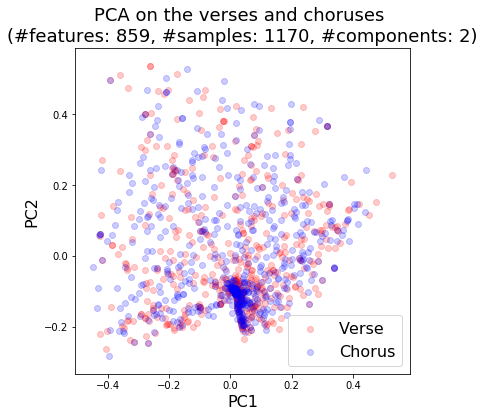

In [66]:
model_pca = PCA_visualization(df_verse = df_bow_verse,
                              df_chorus = df_bow_chorus,
                              vocab = vocab_absolute, 
                              n_comps = 2)

Indeed this results in no clear clusters in 2D and no distinction between choruses and verses.

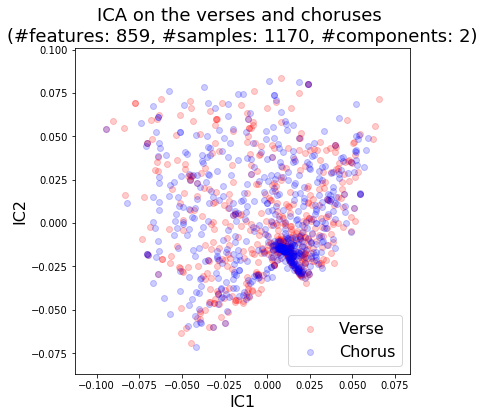

In [67]:
model_ica = FastICA_visualization(df_verse = df_bow_verse,
                                  df_chorus = df_bow_chorus,
                                  vocab = vocab_absolute, 
                                  n_comps = 2)

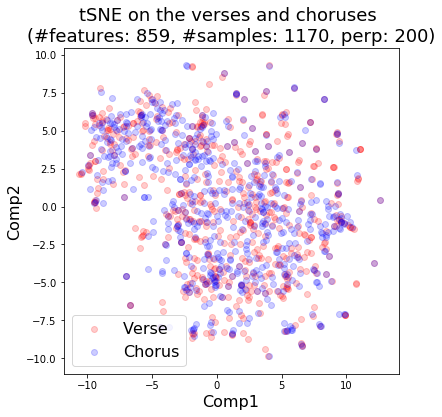

In [131]:
TSNE_visualization(df_verse = df_bow_verse, 
                   df_chorus = df_bow_chorus, 
                   vocab = vocab_absolute,  
                   perplexity = 200)

Both ICA and t-SNE yield similar results, with no clear clustering nor distinction between choruses and verses.

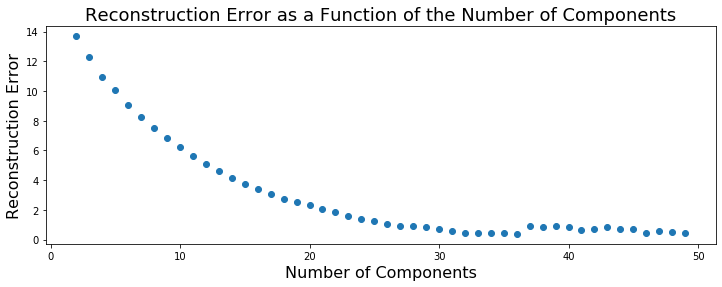

In [129]:
NMF_Optimization_NumberComponents(df_verse = df_bow_verse, 
                                  df_chorus = df_bow_chorus, 
                                  vocab = vocab_absolute, 
                                  max_n_comp = 50)

When trying to optimize NMF and find the required number of components, it is clear that only after 25 components the error stabilizes itself.

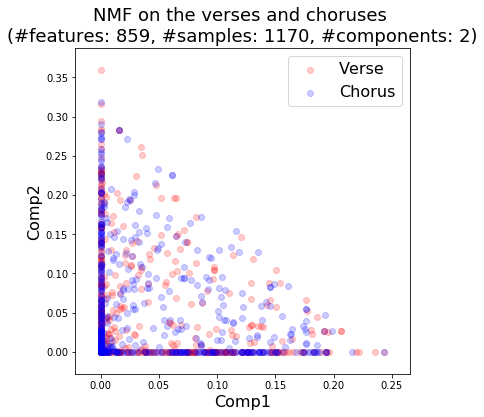

Reconstruction error: 16.97


In [69]:
model_NMF = NMF_visualization(df_verse = df_bow_verse, 
                              df_chorus = df_bow_chorus, 
                              vocab = vocab_absolute, 
                              n_comps = 2)

This is reflected when plotting the results in 2D, where the reconstruction error is still high and no clustering or distinction between choruses and verses appear. We can however observe that the first two components seem to discriminate two groups of songs, with clear lines where one of the component is null.

#### BoW with the concatenated sections and the relative chords

In [70]:
PCA_explainedVariance(df_verse = df_bow_verse_rel,
                      df_chorus = df_bow_chorus_rel,
                      vocab = vocab_relative, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 39.
The PC1 explains 23.85% of the total variance.
The PC2 explains 9.43% of the total variance.
The PC3 explains 8.41% of the total variance.
The PC4 explains 6.31% of the total variance.
The PC5 explains 5.79% of the total variance.
The PC6 explains 4.67% of the total variance.
The PC7 explains 3.58% of the total variance.
The PC8 explains 2.97% of the total variance.
The PC9 explains 2.66% of the total variance.
The PC10 explains 1.94% of the total variance.


This time the number of components required to preserve the variance of the data is lower, at 39, showing how using relative-to-the-tonic chords is indeed better since it isn't affected by the different tonic keys between different songs.

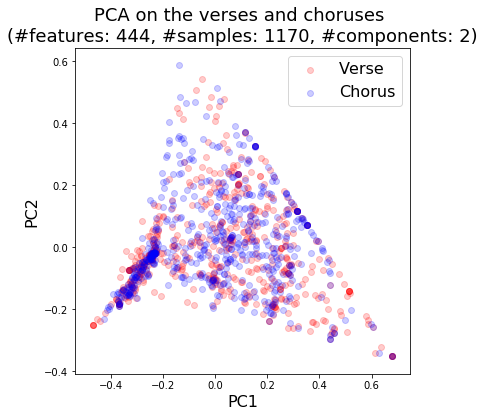

In [71]:
model_pca_rel = PCA_visualization(df_verse = df_bow_verse_rel,
                                  df_chorus = df_bow_chorus_rel,
                                  vocab = vocab_relative, 
                                  n_comps = 2)

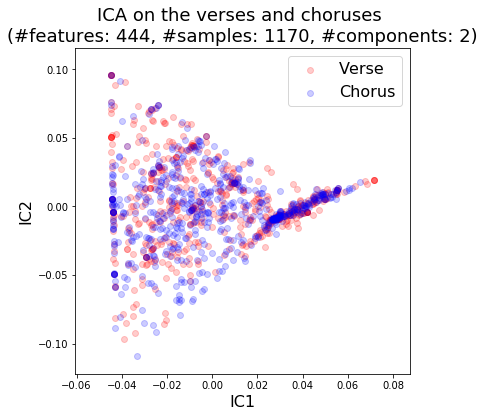

In [72]:
model_ica_rel = FastICA_visualization(df_verse = df_bow_verse_rel,
                                      df_chorus = df_bow_chorus_rel,
                                      vocab = vocab_relative, 
                                      n_comps = 2)

Both PCA and ICA start showing some clustering but it is still quite difficult to have any interpretation.

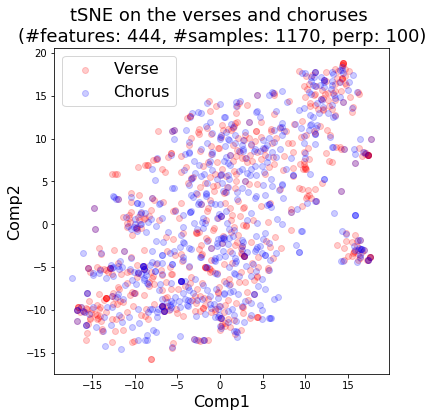

In [73]:
TSNE_visualization(df_verse = df_bow_verse_rel, 
                   df_chorus = df_bow_chorus_rel, 
                   vocab = vocab_relative,  
                   perplexity = 100)

t-SNE continues to not show any clustering or clear distinction between choruses and verses.

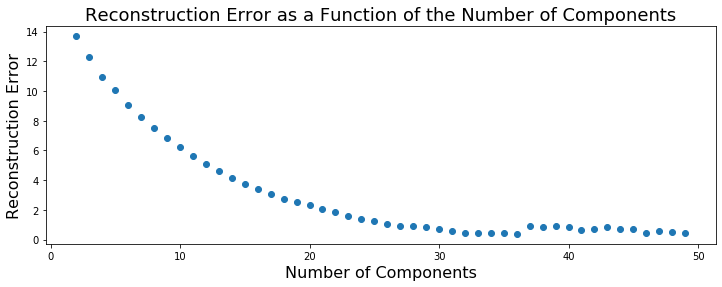

In [132]:
NMF_Optimization_NumberComponents(df_verse = df_bow_verse_rel, 
                                  df_chorus = df_bow_chorus_rel, 
                                  vocab = vocab_relative, 
                                  max_n_comp = 50)

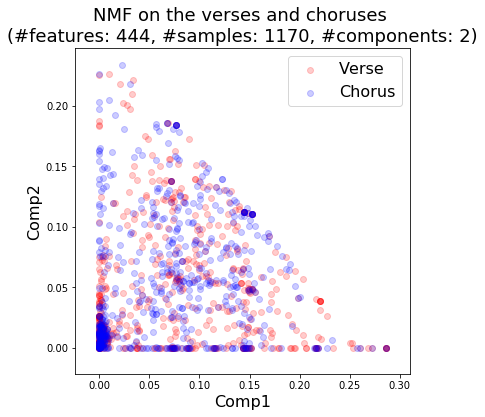

Reconstruction error: 14.43


In [74]:
model_nmf_rel = NMF_visualization(df_verse = df_bow_verse_rel, 
                                  df_chorus = df_bow_chorus_rel, 
                                  vocab = vocab_relative, 
                                  n_comps = 2)

On the other hand, NMF still requires around 25 components to stabilize the reconstruction error and, this time we even lose the clear lines we had before when the first component was null.

#### BoW with the individual sections and the relative chords

In [75]:
PCA_explainedVariance(df_verse = df_bow_verse_rel_seq,
                      df_chorus = df_bow_chorus_rel_seq,
                      vocab = vocab_relative, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 40.
The PC1 explains 23.38% of the total variance.
The PC2 explains 9.33% of the total variance.
The PC3 explains 8.19% of the total variance.
The PC4 explains 6.25% of the total variance.
The PC5 explains 5.64% of the total variance.
The PC6 explains 4.51% of the total variance.
The PC7 explains 3.47% of the total variance.
The PC8 explains 2.75% of the total variance.
The PC9 explains 2.59% of the total variance.
The PC10 explains 2.07% of the total variance.


As expected from previous results about the comparison between concatenated and individual sequences representations, results are pretty much the same as long as we use relative chords.

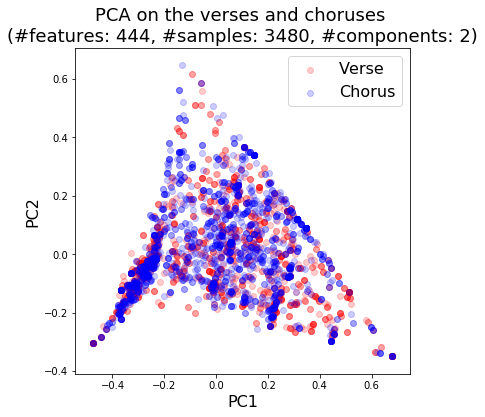

In [76]:
model_pca_rel_seq = PCA_visualization(df_verse = df_bow_verse_rel_seq,
                                      df_chorus = df_bow_chorus_rel_seq,
                                      vocab = vocab_relative, 
                                      n_comps = 2)

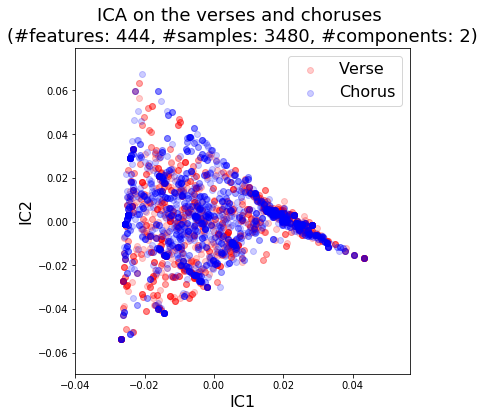

In [77]:
model_ica_rel_seq = FastICA_visualization(df_verse = df_bow_verse_rel_seq,
                                          df_chorus = df_bow_chorus_rel_seq,
                                          vocab = vocab_relative, 
                                          n_comps = 2)

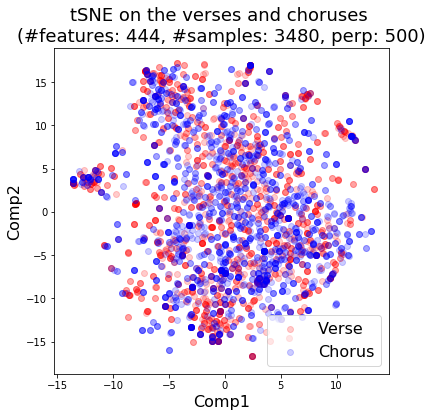

In [78]:
TSNE_visualization(df_verse = df_bow_verse_rel_seq, 
                   df_chorus = df_bow_chorus_rel_seq, 
                   vocab = vocab_relative,  
                   perplexity = 500)

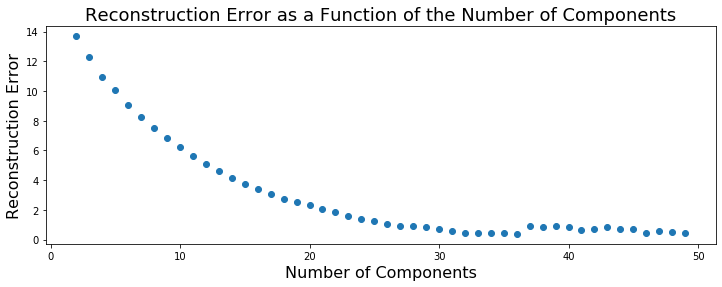

In [134]:
NMF_Optimization_NumberComponents(df_verse = df_bow_verse_rel_seq, 
                                  df_chorus = df_bow_chorus_rel_seq, 
                                  vocab = vocab_relative, 
                                  max_n_comp = 50)

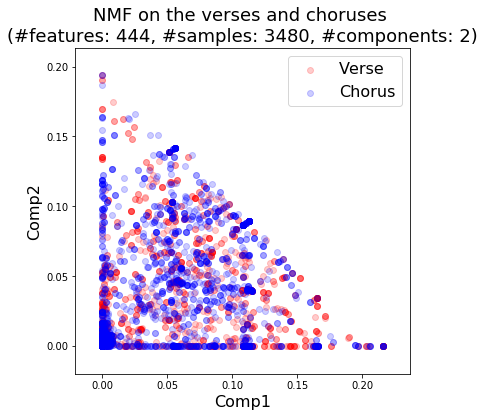

Reconstruction error: 25.73


In [79]:
model_nmf_rel_seq = NMF_visualization(df_verse = df_bow_verse_rel_seq, 
                                      df_chorus = df_bow_chorus_rel_seq, 
                                      vocab = vocab_relative, 
                                      n_comps = 2)

As said, the results are pretty much the same when using concatenated or individual sections, even though the reconstruction error with NMF is higher with individual sections (25.73 against 14.43). This is why we will use the concatenated sequences representation with the aggregated features.

#### BoW with the concatenated sections and the aggregated features 

In [80]:
PCA_explainedVariance(df_verse = df_bow_verse_agg,
                      df_chorus = df_bow_chorus_agg,
                      vocab = features_agg, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 11.
The PC1 explains 29.25% of the total variance.
The PC2 explains 14.43% of the total variance.
The PC3 explains 11.43% of the total variance.
The PC4 explains 7.55% of the total variance.
The PC5 explains 7.06% of the total variance.
The PC6 explains 5.51% of the total variance.
The PC7 explains 4.19% of the total variance.
The PC8 explains 3.44% of the total variance.
The PC9 explains 2.97% of the total variance.
The PC10 explains 2.69% of the total variance.


Finally, the required number of components to explain 90% of the variance drops to only 11, with the first explaining nearly 30% of the variance and the first 4 components explaining slightly more than 60% of the variance of the data.

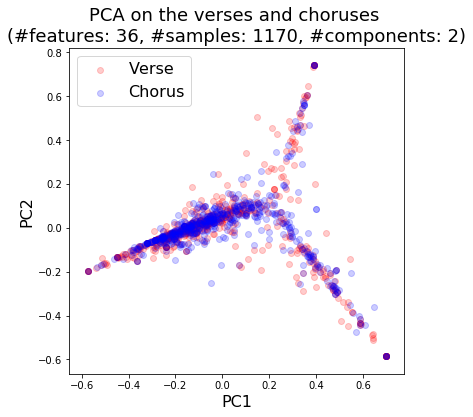

In [81]:
model_pca_agg = PCA_visualization(df_verse = df_bow_verse_agg,
                                  df_chorus = df_bow_chorus_agg,
                                  vocab = features_agg, 
                                  n_comps = 11)

This time, PCA outlines three main regions. Let's also plot PCA in 3D.

In [141]:
from mpl_toolkits.mplot3d import Axes3D

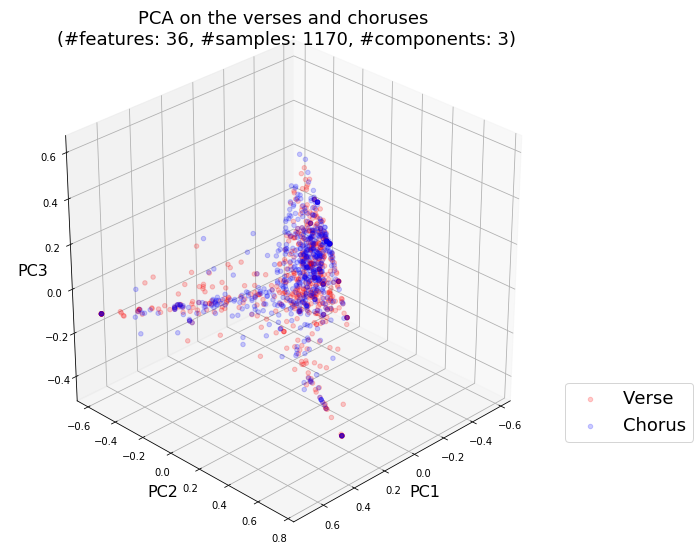

In [151]:
#Train the pca model
X = np.concatenate((df_bow_verse_agg.loc[:, features_agg.keys()].values, df_bow_chorus_agg.loc[:, features_agg.keys()].values))
y = np.concatenate((np.zeros(len(df_bow_verse_agg)), np.ones(len(df_bow_chorus_agg))))
pca_3D = PCA(n_components = 10, svd_solver = "full", random_state = 42)

#Get the principalComponents by fitting the model and transforming the input 
principalComponents = pca_3D.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents[:,:3], columns = ['PC1', 'PC2', 'PC3'])
principalDf['label'] = y

#Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = principalDf[principalDf.label == 0]['PC1'], 
           ys = principalDf[principalDf.label == 0]['PC2'], 
           zs = principalDf[principalDf.label == 0]['PC3'],
           c = 'red',
           alpha = ALPHA,
           label = 'Verse')
ax.scatter(principalDf[principalDf.label == 1]['PC1'], 
           principalDf[principalDf.label == 1]['PC2'], 
           principalDf[principalDf.label == 1]['PC3'],
           c = 'blue',
           alpha = ALPHA,
           label = 'Chorus')
settings = '(#features: ' + str(len(features_agg.keys())) + ', #samples: ' + str(len(X)) + ', #components: 3)'
title = 'PCA on the verses and choruses \n' + settings
plt.title(title, fontsize = TITLE_FS)
ax.set_xlabel('PC1', fontsize = AX_LABEL_FS)
ax.set_ylabel('PC2', fontsize = AX_LABEL_FS)
ax.set_zlabel('PC3', fontsize = AX_LABEL_FS)
ax.view_init(30, 45)
plt.legend(fontsize = 18, loc = (1,0.2))
plt.show()

When plotting in 3D, we see that the big cluster we were seeing in the left half of the previous graph is in fact spread out across PC3. Let's investigate the corresponding weights vectors to better understand what is happening here.

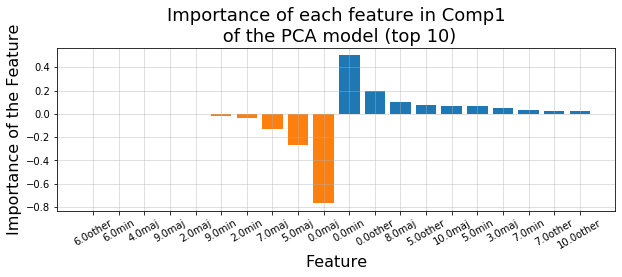

In [138]:
InspectWeightVector(weights = model_pca_agg.components_, 
                        pc = 1, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'PCA')

The first PC seems to mainly discriminate sequences based on tonic minor (0min) and tonic major (0maj) chords. In particular, the large cluster of points in the left half of the PCA graph corresponds to sequences with a lot of tonic major chords. This goes back to previous results were we highlighted that tonic major were the most common chords in our corpus, resulting here in the biggest cluster of points.

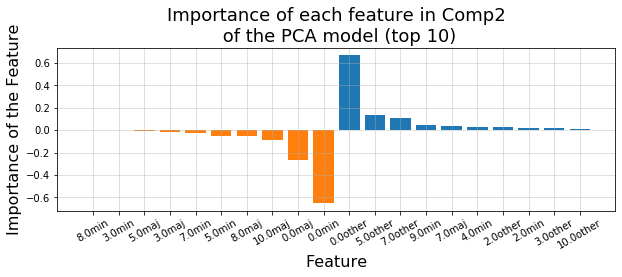

In [139]:
InspectWeightVector(weights = model_pca_agg.components_, 
                        pc = 2, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'PCA')

The second PC discriminates between tonic major or minor and other tonic chords. It would seem that verses and choruses with tonic that are neither in major or minor are clustered together with positive PC2 values while negative PC2 values correspond to verses and choruses with more tonic major or minor.

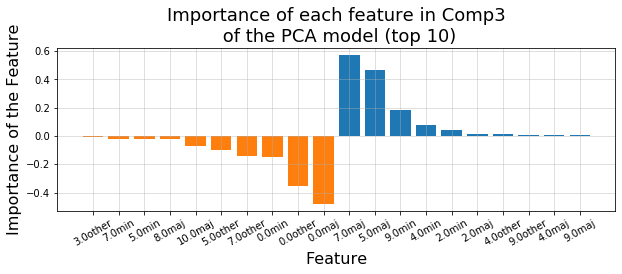

In [140]:
InspectWeightVector(weights = model_pca_agg.components_, 
                        pc = 3, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'PCA')

Finally, the third PC discriminates among the different qualities of major chords, with positive weights on 7maj and 5maj and a negative weight for 0maj.

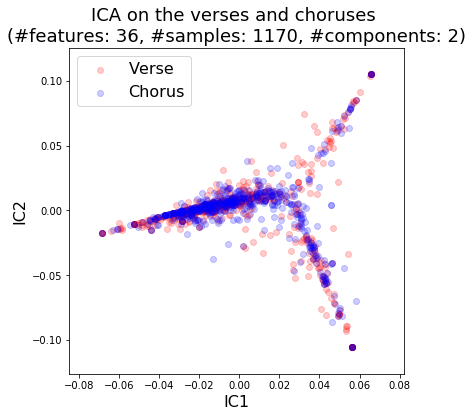

In [157]:
model_ica_agg = FastICA_visualization(df_verse = df_bow_verse_agg,
                                      df_chorus = df_bow_chorus_agg,
                                      vocab = features_agg, 
                                      n_comps = 2)

With 2-components ICA, the results are pretty much the same as with 2D-PCA. We can here as well inspect the corresponding weight vectors.

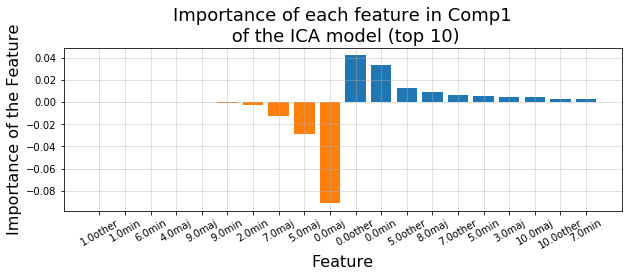

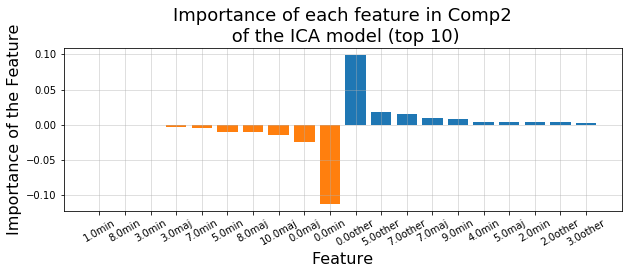

In [84]:
for i in range(1,3):
    InspectWeightVector(weights = model_ica_agg.components_, 
                        pc = i, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'ICA')

As in PCA, the first component discriminates between tonic major (0maj) and remaining tonic chords (0other and 0min). This time however the weight on 0other is stronger than the one on 0min. For the second component the results are pretty much identical with the ones of PCA, with a discrimination based on the presence on tonic minor (in negative) and other tonic (in positive).

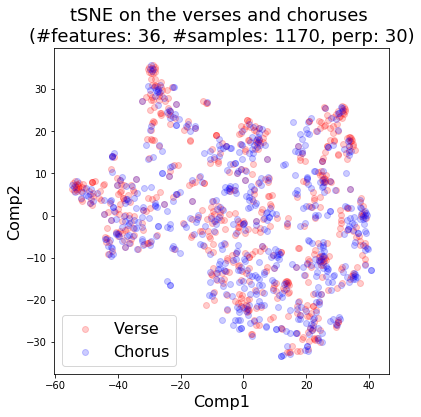

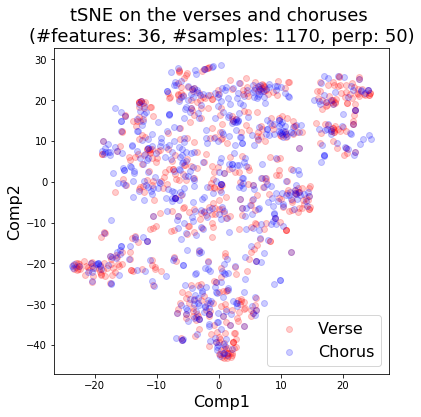

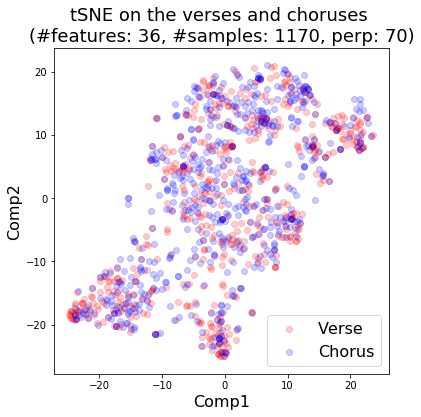

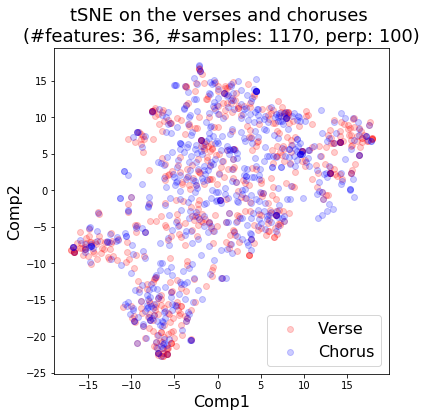

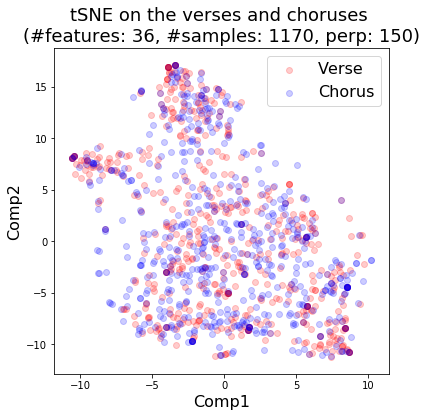

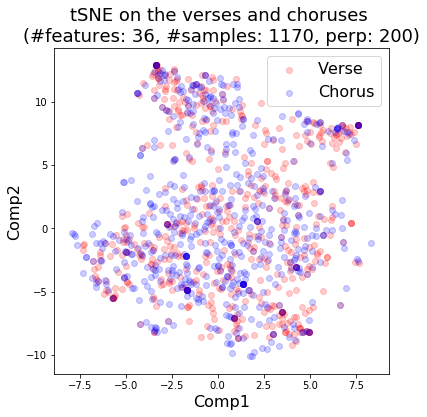

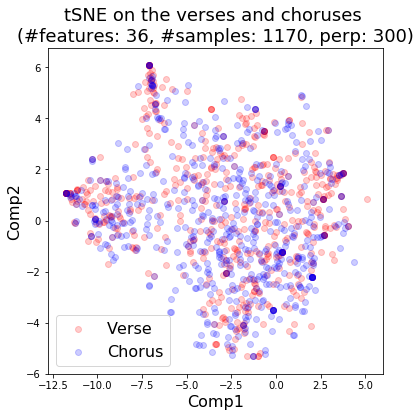

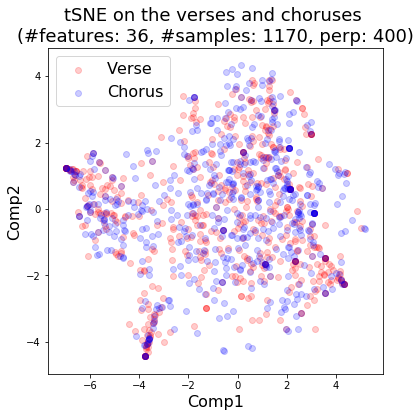

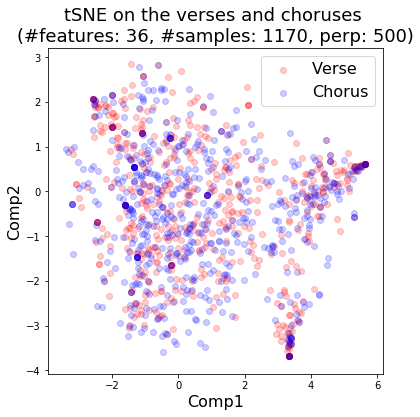

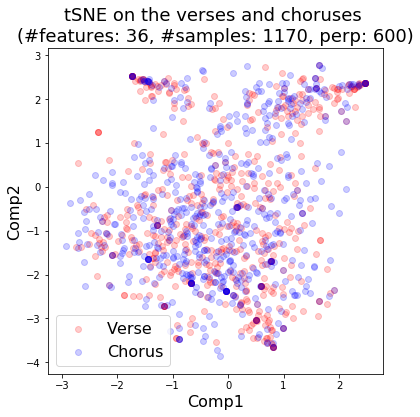

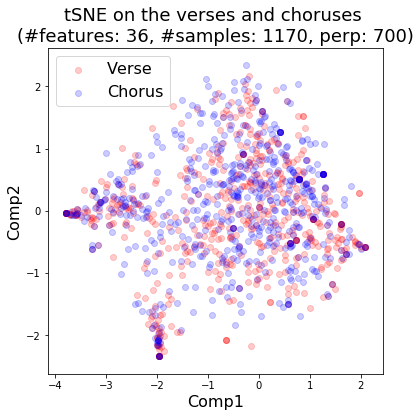

In [163]:
for perp in [30, 50, 70, 100, 150, 200, 300, 400, 500, 600, 700]:
    TSNE_visualization(df_verse = df_bow_verse_agg, 
                   df_chorus = df_bow_chorus_agg, 
                   vocab = features_agg,  
                   perplexity = perp)

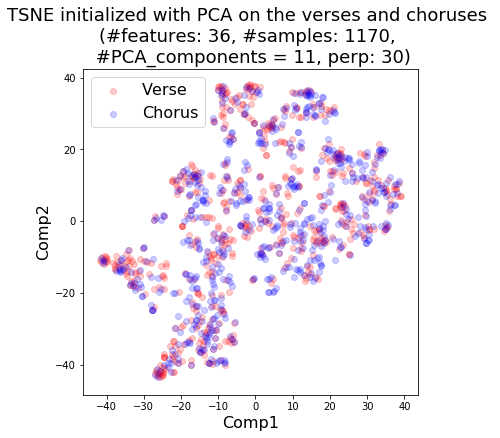

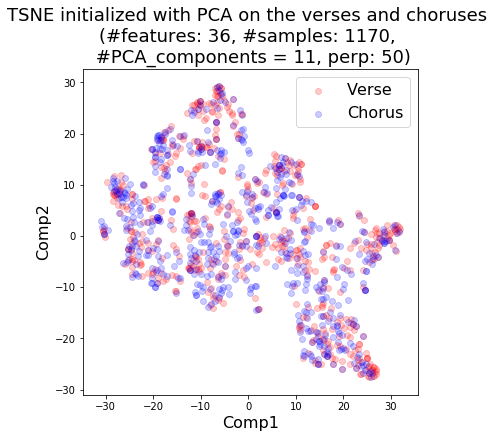

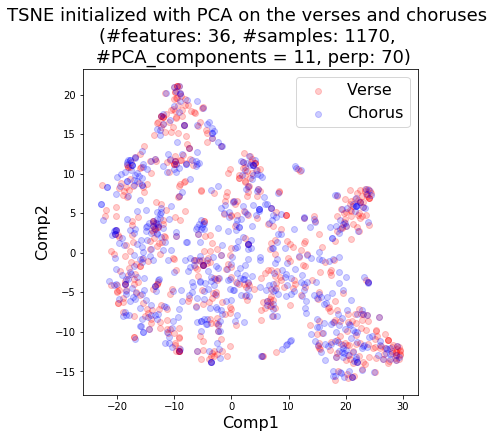

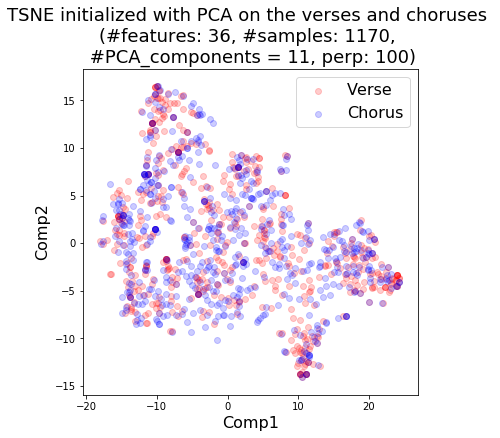

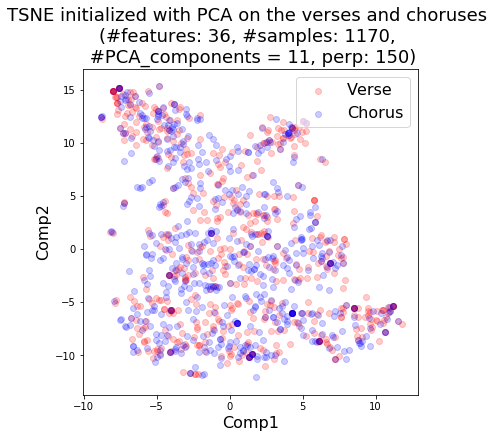

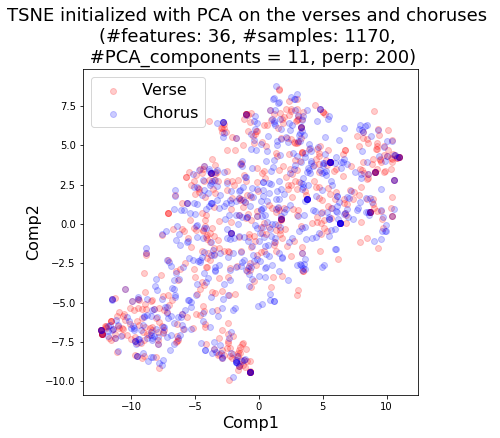

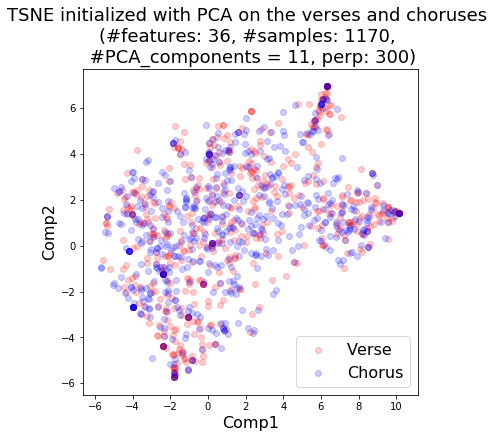

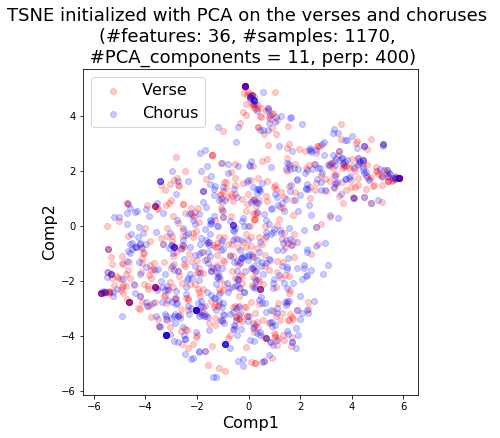

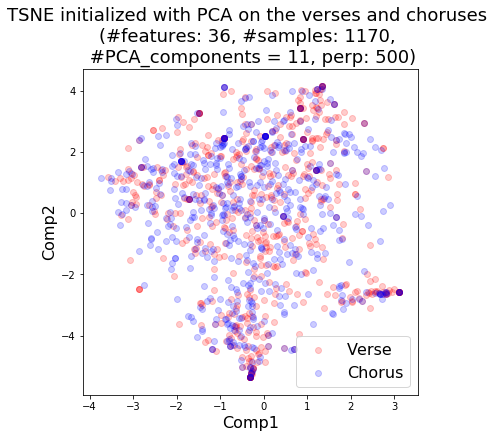

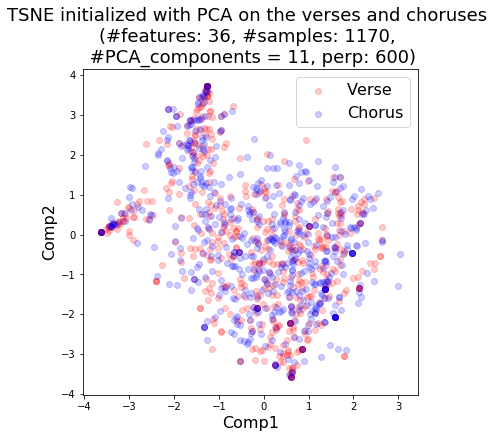

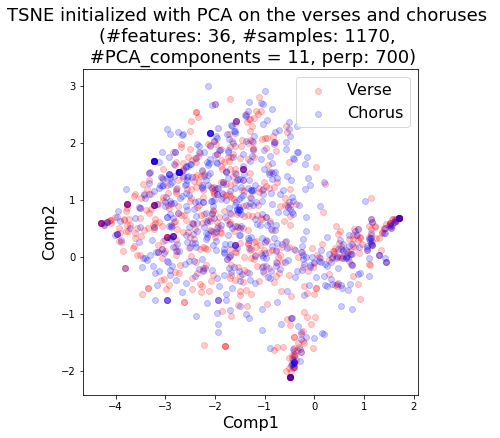

In [164]:
for perp in [30, 50, 70, 100, 150, 200, 300, 400, 500, 600, 700]:
    TSNE_PCAinit(df_verse = df_bow_verse_agg, 
                 df_chorus = df_bow_chorus_agg,
                 vocab = features_agg,
                 pca_comps = 11,
                 perplexity = perp)

For t-SNE, we have tried different perplexity values, both with and without PCA initialization, but the algorithm wasn't able to cluster the data in any meaningful way. Some soft clusters might be present but overall it is extremely noisy and it is fairly safe to conclude that t-SNE is not a suitable data to visualize this dataset in low-dimension space.

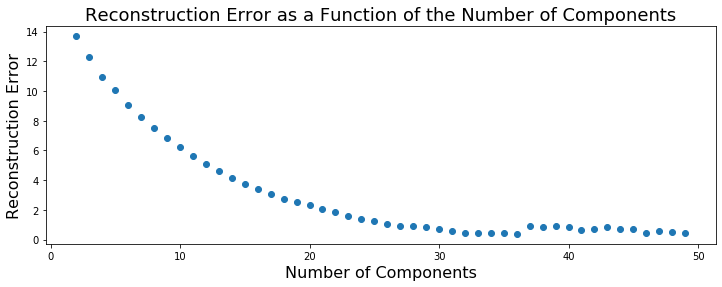

In [130]:
NMF_Optimization_NumberComponents(df_verse = df_bow_verse_agg, 
                                  df_chorus = df_bow_chorus_agg, 
                                  vocab = features_agg, 
                                  max_n_comp = 50)

As in previous cases, the optimal number of components for NMF remains around 25.

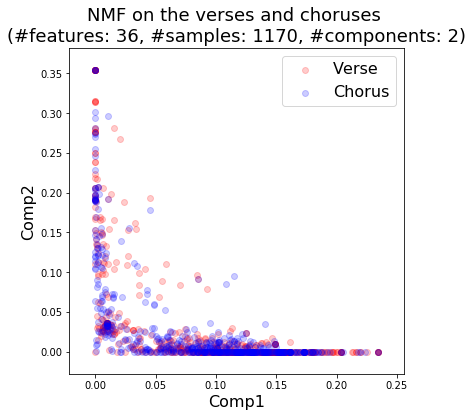

Reconstruction error: 13.67


In [170]:
nmf_model_agg = NMF_visualization(df_verse = df_bow_verse_agg, 
                                  df_chorus = df_bow_chorus_agg, 
                                  vocab = features_agg, 
                                  n_comps = 2)

With the 2D plot, we get the lowest reconstruction error among all representations we have tried, even though it is still quite high. We also get the two characteristic lines when one of the component is null. Let's inspect the corresponding weights.

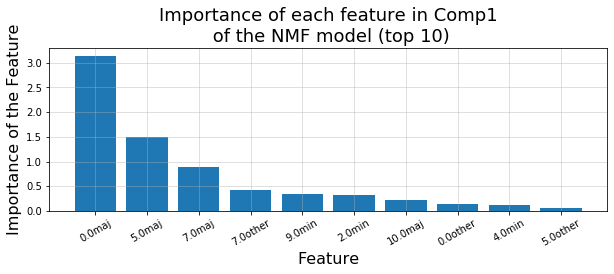

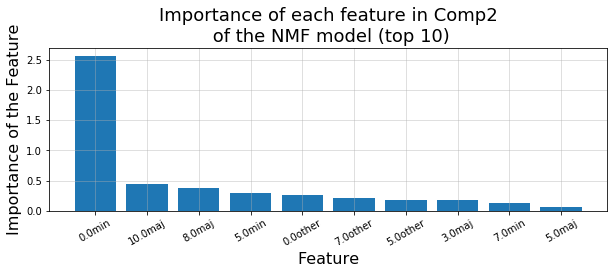

In [171]:
InspectNMFWeightVectors(weights = nmf_model_agg.components_, 
                        vocab = features_agg, 
                        n_comps = 2, 
                        n_weights = 10)

The first component relies mostly on major chords, with higher weights on tonic and dominant major chords, while the second component is mainly affected by tonic minor chords. Since major chords are the most present in the verses and choruses of our corpus, it makes sense that the biggest cluster identified by NMF is spread across values of the first component.

# Discussion of the results